In [1]:
import pandas_datareader as web
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')


In [2]:
# Collecte de données
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2019-09-05')

df_web_aapl = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)[:2156]
df_web_aapl.columns = ['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Close_AAPL', 'Volume_AAPL', 'Adj_Close_AAPL']
df_web_aapl=df_web_aapl[['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Close_AAPL','Adj_Close_AAPL']]
df_web_aapl=df_web_aapl[['High_AAPL', 'Close_AAPL', 'Low_AAPL', 'Open_AAPL','Adj_Close_AAPL']]

df_web_gold = web.DataReader('GOLD', data_source='yahoo', start=start, end=end)[:2156]
df_web_gold.columns = ['High_GOLD', 'Low_GOLD', 'Open_GOLD', 'Close_GOLD', 'Volume_GOLD', 'Adj_Close_GOLD']
df_web_gold = df_web_gold[['Adj_Close_GOLD']]

df_web_vix = web.DataReader('^VIX', data_source='yahoo', start=start, end=end)
df_web_vix.columns = ['High_VIX', 'Low_VIX', 'Open_VIX', 'Close_VIX', 'Volume_VIX', 'Adj_Close_VIX']
df_web_vix = df_web_vix[['Close_VIX']]

In [3]:
#Création de la moyenne mobile
df_ema_close_aapl = pd.Series.ewm(df_web_aapl[['Close_AAPL']], span=26).mean()
df_ema_close_aapl.columns = ['moyenne_mobile']

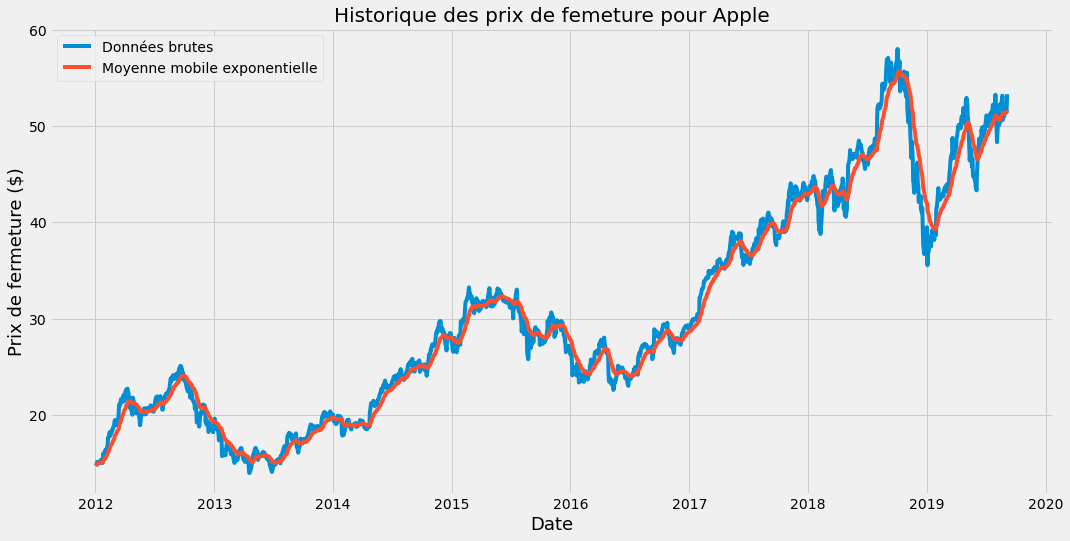

In [4]:
# Visualisation des prix de fermeture
plt.figure(figsize=(16,8))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
plt.plot(df_web_aapl['Close_AAPL'])
plt.plot(df_ema_close_aapl)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.legend(['Données brutes','Moyenne mobile exponentielle'])
plt.show()

In [5]:
#Dataframe des données
df = pd.concat([df_web_aapl,df_web_gold,df_web_vix,df_ema_close_aapl],axis=1)

In [6]:
df

,High_AAPL,Close_AAPL,Low_AAPL,Open_AAPL,Adj_Close_AAPL,Adj_Close_GOLD,Close_VIX,moyenne_mobile
Date,,,,,,,,
2012-01-03,14.732142,14.686786,14.607142,14.621428,12.566676,41.618229,22.969999,14.686786
2012-01-04,14.810000,14.765715,14.617143,14.642858,12.634213,42.240177,22.219999,14.727768
2012-01-05,14.948215,14.929643,14.738214,14.819643,12.774481,42.064991,21.480000,14.800300
2012-01-06,15.098214,15.085714,14.972143,14.991786,12.908023,41.644520,20.629999,14.880089
2012-01-09,15.276786,15.061786,15.048214,15.196428,12.887549,41.793423,21.070000,14.922225
...,...,...,...,...,...,...,...,...
2019-08-29,52.330002,52.252499,51.665001,52.125000,51.230591,18.917578,17.879999,51.381356
2019-08-30,52.612499,52.185001,51.799999,52.540001,51.164417,19.015696,18.980000,51.440885
2019-09-03,51.744999,51.424999,51.055000,51.607498,50.419273,19.054945,19.660000,51.439708


In [7]:
#Création de la colonne target
df_target = df[['Close_AAPL']].shift(periods=-1)
df_target = df_target[:-1]

In [8]:
#On transforme les données en numpy
df_data = df[:-1]
df_data
X=df_data.to_numpy()

In [9]:
#On transforme le target en numpy
y=df_target.to_numpy()

In [10]:
#On normalise les données
scaler_data = MinMaxScaler(feature_range=(0,1))
X = scaler_data.fit_transform(X)

scaler_target = MinMaxScaler(feature_range=(0,1))
y = scaler_target.fit_transform(y)

In [11]:
#On divise le dataset en training et test
n = int(len(X) *0.9)

X_train = X[:n]
X_test = X[n:]

y_train = y[:n]
y_test = y[n:]


In [12]:
#Apprentissage
y_train = np.reshape(y_train,(y_train.shape[0],))
y_test = np.reshape(y_test,(y_test.shape[0],))

from sklearn.neural_network import MLPRegressor
mlp=MLPRegressor(max_iter=1000,solver='lbfgs',random_state=0,hidden_layer_sizes=[100,100],alpha=0.1)
mlp.fit(X_train,y_train)
print (mlp.score(X_train,y_train))
print (mlp.score(X_test,y_test))

0.9976336850551504
0.964513234707328


In [13]:
#On remet les données prédites à l'échelle initiale
y_prediction = mlp.predict(X_test)
y_prediction = np.reshape(y_prediction,(y_prediction.shape[0],1))
y_prediction = scaler_target.inverse_transform(y_prediction)

In [14]:
#On met les données prédites en pandas
df_prediction = df_target[n:].copy()
df_prediction.columns = ['Prédiction'] 
df_prediction['Prédiction'] = y_prediction

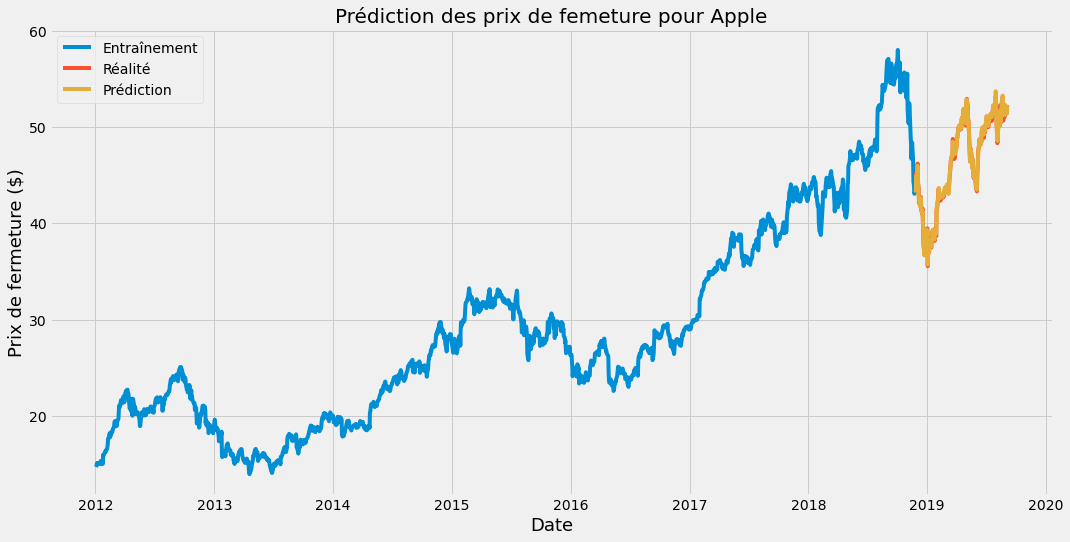

In [15]:
#Visualisation des résultats

plt.figure(figsize=(16,8))
plt.title('Prédiction des prix de femeture pour Apple', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.plot(df_data['Close_AAPL'][:n])
plt.plot(df_data['Close_AAPL'][n:])
plt.plot(df_prediction['Prédiction'])
plt.legend(['Entraînement','Réalité','Prédiction'])
plt.show()

In [16]:
#Calcul de l'erreur
MSE = ((df_prediction['Prédiction'] - df_data['Close_AAPL'][n:])**2).mean()
MSE

0.05082140141087329

In [17]:
#Calcul de l'erreur de la préediction naïve
MSE = ((df_target['Close_AAPL'] - df_data['Close_AAPL'][n:])**2).mean()
MSE

0.772147605396277

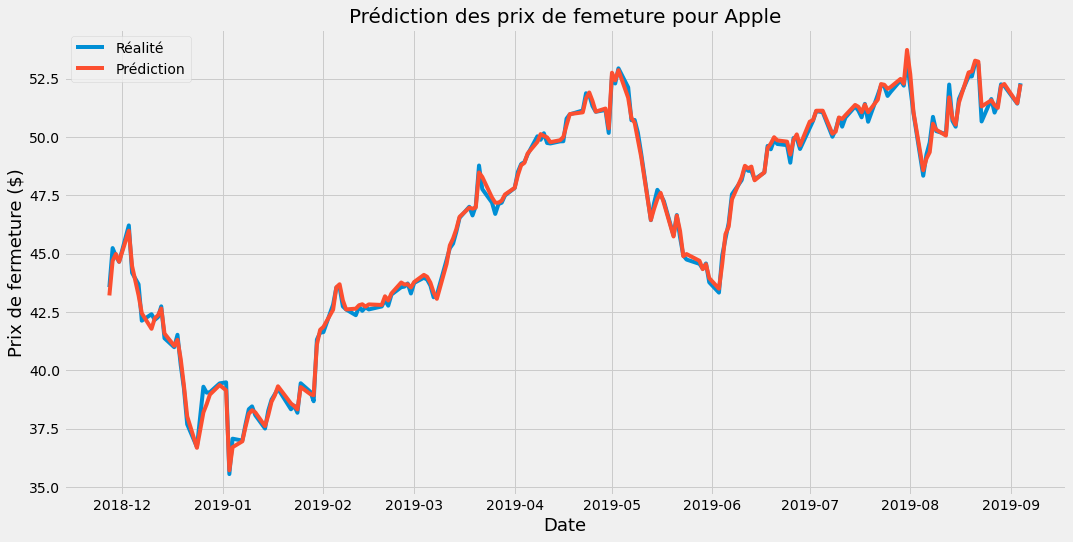

In [18]:
#Visualisation des résultats

plt.figure(figsize=(16,8))
plt.title('Prédiction des prix de femeture pour Apple', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.plot(df_data['Close_AAPL'][n:])
plt.plot(df_prediction['Prédiction'])
plt.legend(['Réalité','Prédiction'])
plt.show()